# Overview

## Output Files:
- SQGDP9_US_2005_2022.csv
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv
- rsmeans_wtavgs_st.csv
- nationwide_constr_spend_qtr.csv

## BEA Construction Data

### Input:
- SQGDP9_AK_2005_2022.csv
- SQGDP9_AL_2005_2022.csv
- ...
- SQGDP9_WV_2005_2022.csv
- SQGDP9_WY_2005_2022.csv

### Output:
- SQGDP9_US_2005_2022.csv

## AON Damages Data

### Input: 
- Aon Damages by Time Location and Amount 2004 to 2022.xlsx

### Output:  
- Aon_US_Damage_2004_to_2022.csv
- Aon_US_Damage_2004_to_2022_dropped.csv

## RSMeans Data

### Input:
- rsmeans.pkl

### Output:
- rsmeans.csv

## US Construction GDP Data

### Input:
- nationwide_constr_spend.xlsx

### Output:
- nationwide_constr_spend_qtr.csv

## Preliminaries

In [2]:
# set to true to create output files again
create_output_files = False

In [3]:
import pandas as pd
import numpy as np
import re
import glob
import os
import pickle
import datetime

### Files and Directories

In [4]:
# Base
#base_dir = "./Rich"
base_dir = '/content/drive/MyDrive/environment'
out_dir = os.path.join(base_dir,"out2")

# FEMA
fema_in_file = "HELP HELP.xlsx"
#fema_in_file = "HELP HELP2.xlsx"
fema_fed_out_file = "fema_fed_by_month.csv"
fema_st_out_file = "fema_state_by_month.csv"
fema_tot_out_file = "fema_total_by_month.csv"

fema_err_dt1_out_file = "fema_err_start_date.csv"
fema_err_dt2_out_file = "fema_err_end_date.csv"
fema_err_tot_spend = "fema_err_total_spend.csv"
fema_err_fed_spend = "fema_err_fed_spend.csv"
fema_err_st_spend = "fema_err_state_spend.csv"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Process FEMA

In [6]:
#base_dir = '/content/drive/MyDrive/environment'
#print(os.path.join(base_dir,fema_in_file))
#!head /content/drive/MyDrive/environment/HELP\ HELP2.xlsx
dffema = pd.DataFrame(pd.read_excel(os.path.join(base_dir,fema_in_file),header=1,sheet_name='HELP',
                                    usecols=np.arange(12).tolist()))

In [ ]:
display(dffema)

In [12]:
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].str.strip()
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].replace('$','')
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].str.replace('$','')
#dffema["STATE SPEND"] = dffema["STATE SPEND"].str.replace('$','')
#dffema["TOTAL PROJECT SPEND"] = dffema["TOTAL PROJECT SPEND"].str.replace('$','')
#display(dffema)
dffema["TOTAL PROJECT SPEND"] = pd.to_numeric(dffema["TOTAL PROJECT SPEND"], errors='coerce').fillna(0).astype('float').round(2)
dffema["FED SPEND"] = pd.to_numeric(dffema["FED SPEND"], errors='coerce').fillna(0).astype('float').round(2)
dffema["STATE SPEND"] = pd.to_numeric(dffema["STATE SPEND"], errors='coerce').fillna(0).astype('float').round(2)
dffema["START YR"] = pd.to_numeric(dffema["START YR"], errors='coerce').fillna(0).astype('int')
dffema["START MO"] = pd.to_numeric(dffema["START MO"], errors='coerce').fillna(0).astype('int')
dffema["END YR"] = pd.to_numeric(dffema["END YR"], errors='coerce').fillna(0).astype('int')
dffema["END MO"] = pd.to_numeric(dffema["END MO"], errors='coerce').fillna(0).astype('int')

In [16]:
#dffema[(dffema["FED SPEND"] + dffema["STATE SPEND"]).round(2) != dffema["TOTAL PROJECT SPEND"]]
dffema[(dffema["TOTAL PROJECT SPEND"] == 0.0) & ((dffema["FED SPEND"] > 0.0) | (dffema["STATE SPEND"] > 0.0))]


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
5711,PUBLIC ASSISTANCE,Severe Ice Storm,Red River,TX,2001,1,2001,2,1.0,0.0,0.01,0.0
5712,PUBLIC ASSISTANCE,Severe Ice Storm,Red River,TX,2001,1,2001,2,1.0,0.0,0.01,0.0
19149,PUBLIC ASSISTANCE,Severe Storm,San Diego,CA,2005,2,2005,3,1.0,0.0,0.01,0.0
19746,PUBLIC ASSISTANCE,Hurricane,Butler,AL,2005,7,2005,8,1.0,0.0,0.01,0.0
30294,PUBLIC ASSISTANCE,Severe Storm,Statewide,WV,2009,5,2009,6,1.0,0.0,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010,8,3361725,0,NaN,0.0,3361725.14,0.0
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010,8,3753216,0,NaN,0.0,3753216.85,0.0
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010,8,4084102,0,NaN,0.0,4084102.26,0.0
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010,8,4770400,0,NaN,0.0,4770400.99,0.0


In [ ]:
#dffema[dffema["END MO"]<1 & dffema["END MO"]>12]["END MO"] = dffema[dffema["END MO"]<1 & dffema["END MO"]>12]["START MO"]
#dffema[dffema["END YR"]<1 & dffema["END MO"]>12]["END MO"] = dffema[dffema["END MO"]<1 & dffema["END MO"]>12]["START YR"]
baddates = ((dffema["END MO"]<1) | (dffema["END MO"]>12))
#display(dffema[(dffema["END MO"]<1) | (dffema["END MO"]>12)])
#display(dffema[baddates])
dffema.loc[baddates,"END YR"] = dffema[baddates]["START YR"]
dffema.loc[baddates,"END MO"] = dffema[baddates]["START MO"]
#print(dffema["FED SPEND"])
#dffema["FED SPEND"] = dffema["FED SPEND"].replace('-','')
#dffema["FED SPEND"] = dffema["FED SPEND"].fillna(0).astype(float).round(2)

In [8]:
#help(pd.read_excel)
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1.0,1039431.28,1039431.28,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1.0,2664.51,1998.38,666.13
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1.0,22914.27,17185.70,5728.57
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1.0,$-,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1.0,70000,70000.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
950542,HOUSING ASSISTANCE RENTERS,NaN,53216,WI,2010,8,2010,8,NaN,,3361725.14,0.00
950543,HOUSING ASSISTANCE RENTERS,NaN,53218,WI,2010,8,2010,8,NaN,,3753216.85,0.00
950544,HOUSING ASSISTANCE RENTERS,NaN,53209,WI,2010,8,2010,8,NaN,,4084102.26,0.00
950545,HOUSING ASSISTANCE RENTERS,NaN,53206,WI,2010,8,2010,8,NaN,,4770400.99,0.00


In [21]:
dferr = dffema[pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str), errors="coerce").isna()]
display(dferr)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
779427,EMERGENCY MANAGEMENT PERFORMANCE GRANTS,NaN,Howard County Office of Emergency Management,Maryland,0,0,2021,9,NaN,0,6556.51,-6556.51
780154,EMERGENCY MANAGEMENT PERFORMANCE GRANTS,NaN,Caswell County,North Carolina,0,0,2023,9,NaN,0,39285.88,-39285.88
782750,HOUSING ASSISTANCE OWNERS,NaN,34974,FL,0,0,0,0,NaN,,340.32,0.00
799642,HOUSING ASSISTANCE OWNERS,NaN,19709,DE,0,0,0,0,NaN,,1756.20,0.00
828143,HOUSING ASSISTANCE OWNERS,NaN,33440,FL,0,0,0,0,NaN,,9334.60,0.00


In [25]:
dferr.to_csv(os.path.join(base_dir,fema_err_dt1_out_file))

In [26]:
dferr = dffema[pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str), errors="coerce").isna()]
display(dferr)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND
777342,EMERGENCY MANAGEMENT PERFORMANCE GRANTS,NaN,NX Clay County,Texas,2015,10,3016,9,NaN,0,28117.36,-28117.36
778584,EMERGENCY MANAGEMENT PERFORMANCE GRANTS,NaN,SP City of Lubbock,Texas,2017,10,3018,9,NaN,0,61266.55,-61266.55
782750,HOUSING ASSISTANCE OWNERS,NaN,34974,FL,0,0,0,0,NaN,,340.32,0.00
799642,HOUSING ASSISTANCE OWNERS,NaN,19709,DE,0,0,0,0,NaN,,1756.20,0.00
828143,HOUSING ASSISTANCE OWNERS,NaN,33440,FL,0,0,0,0,NaN,,9334.60,0.00


In [27]:
dferr.to_csv(os.path.join(base_dir,fema_err_dt2_out_file))

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
from scipy.stats import rvs_ratio_uniforms
from sympy import *
import sympy
import scipy.stats as stats
#from scipy.stats import truncnorm

In [ ]:
seed = 47563
rng = np.random.default_rng(seed)
days = 90
spend = 500000
mu = days/2
sigma = days/6

a, b = (0 - mu) / sigma, ((days-1) - mu) / sigma

#X = stats.truncnorm(0, days-1, loc=mu, scale=sigma)
#stats.truncnorm(0, days-1, loc=mu, scale=sigma)
vals = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,size=spend,random_state=rng).round().astype(int)

#print(rng.random())
#vals = np.clip(rng.normal(mu,sigma,spend).round().astype(int),0,days-1)
#vals = np.clip(rng.normal(days/2,days/6,spend).round().astype(int),0,days-1)
#vals = np.clip(np.random.gamma(40,.5,spend).round().astype(int),0,days-1)
print(np.bincount(vals))
np.bincount(vals).sum()
#$print(vals.sum())

[   98   158   229   257   325   395   472   523   684   762   899  1016
  1156  1350  1537  1761  2059  2350  2533  2937  3340  3758  4211  4600
  5083  5473  6017  6547  6963  7566  8102  8583  9237  9625 10242 10802
 11343 11541 11821 12192 12870 12835 13153 13141 13275 13242 13178 13220
 13043 12854 12450 12147 12250 11649 11027 10550 10328  9559  9091  8663
  7945  7738  7041  6532  5989  5511  5083  4573  4028  3744  3280  2945
  2566  2305  2093  1776  1582  1378  1166  1006   918   737   703   536
   422   408   314   281   225   103]


500000

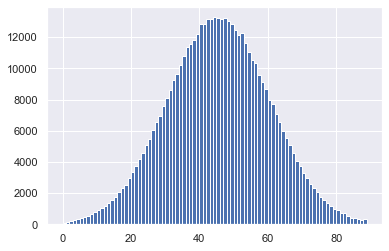

In [ ]:
_ = plt.hist(vals,bins=np.arange(days))

In [ ]:
from pandas.tseries.offsets import MonthEnd

month1, year1 = 2, 2011
month2, year2 = 3, 2015
#print(pd.to_datetime(f"{month1} {year1}") + MonthEnd(0))
print(pd.to_datetime(f"{month2} {year2}") + MonthEnd(0))
dt2 = pd.to_datetime(f"{month2} {year2}") + MonthEnd(0)
#f"{year}-{month}-1"
#print(pd.Period(f"{month1} {year1}").daysinmonth)
#print(pd.Period(f"{year1}-{month1}-1").daysinmonth)
#print(pd.date_range(start='2019-11-22', periods=10, freq='D').to_period('M').value_counts())
print(len(pd.date_range(start=f"{month1} {year1}", end=dt2, freq='D')))

2015-03-31 00:00:00
1520


In [ ]:
# step 1: add column for # of days in the specified months
# step 2: add columns for mu and sigma
# step 3: add columns for a and b
# step 4: add column for normal/gamma/other distribution over # of days (list with len == # days)
# step 5: add column for number of days for each month in range (list with len == # months)
# step 6: add column for month/year values (adds dist. vals from step 4 for # days/month in step 5)
#         (list of total month/year costs with len == # months)
# step 7: add column for offset to align start month/year with month/year column
# step 8: update the values in columns starting at the offset calcuated in step 7 with the 
#         values created in step 6 (not sure how to do this, but maybe "apply" method?)
# step 9: drop the columns added in steps 1-7
# step 10: create column that totals the month/year columns
# step 11: write any lines (ideally, including line number) to an error file

In [ ]:
#dffemacopy = dffema.copy()

In [ ]:
dffema = dffemacopy.copy()

In [ ]:
#display(dffema)
#len(dffema.columns)
#help(dffema.reindex)
use_gaussian = False

In [ ]:
dt1 = pd.to_datetime("2 2018")
dt2 = pd.to_datetime("5 2019") + MonthEnd(0)
days = len(pd.date_range(start=dt1, end=dt2, freq='D'))
print(days)
print(sum(pd.date_range(start=dt1, end=dt2, freq='M').daysinmonth))
#pd.date_range(start=dt1, end=dt2, freq='D')
a = np.arange(days)
pd.date_range(start=dt1, end=dt2, freq='M').daysinmonth

dr = pd.date_range(start=dt1, end=dt2, freq='D')
mr = pd.date_range(start=dt1, end=dt2, freq='M')

df = pd.DataFrame({"val":a},index=dr)
#df.index.name = "day"
display(df.index)
df = df.groupby(df.index.strftime('%Y-%m')).sum().reset_index()
#df.groupby(index.dt.strftime('%Y-%m')).sum().reset_index()
df.val.tolist()
#df.index

485
485


DatetimeIndex(['2018-02-01', '2018-02-02', '2018-02-03', '2018-02-04',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-10',
               ...
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29',
               '2019-05-30', '2019-05-31'],
              dtype='datetime64[ns]', length=485, freq='D')

[378,
 1333,
 2205,
 3224,
 4035,
 5115,
 6076,
 6795,
 7967,
 8625,
 9858,
 10819,
 10598,
 12648,
 13155,
 14539]

In [ ]:
def split_spending(row,col_name):
    dt1 = pd.to_datetime(str(row["START MO"]) + " " + str(row["START YR"]))
    dt2 = max(pd.to_datetime(str(row["START MO"]) + 
                                           " " + str(row["START YR"])),
                            pd.to_datetime(str(row["END MO"]) + 
                                           " " + str(row["END YR"]))) + MonthEnd(0)
    #print(row.index.tolist())
    if(dt1 != dt2):
        dtr = pd.date_range(start=dt1, end=dt2, freq='M').strftime("%Y-%m")
        if use_gaussian:
            #spend = int(row["FED SPEND"]*100)
            spend = int(row[col_name]*100)
            days = len(pd.date_range(start=dt1, end=dt2, freq='D'))
            #print(days)
            mu = days/2
            sigma = days/6
            a, b = (0 - mu) / sigma, ((days-1) - mu) / sigma
            seed = 47563
            rng = np.random.default_rng(seed)
            vals = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,size=spend,random_state=rng).round().astype(int)
            vals = np.bincount(vals)
            #print(len(vals))
            #print(len(dtr.tolist()))
            df = pd.DataFrame({"val":vals},index=pd.date_range(start=dt1, end=dt2, freq='D'))
            #print(len(df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val.tolist()))
            #row[dtr.tolist()] = ((df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val)/100).tolist()
            row[dtr.tolist()] = df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val.tolist()
            #print('......................')
        else:
            #print(dtr.tolist())
            dtrlst = dtr.tolist()
            row[dtrlst] = round(row[col_name]/len(dtrlst),2)
            tmp = round(row[dtr.tolist()].sum(),2)
            if tmp > row[col_name]:
                tmp = round(tmp-row[col_name],2)
                # reduce tails
                row[dtrlst[0]] -= round(tmp/2,2)
                if tmp > .01:
                    row[dtrlst[-1]] -= round(tmp/2 + (0. if (int(tmp)*100)%2 == 0 else .01),2)
            elif tmp < row[col_name]:
                # pad center
                row[dtrlst[int(len(dtrlst)/2)]] += round(row[col_name]-tmp,2)
    else:
        row[dt1.strftime("%Y-%m")] = row[col_name]
    #print(".....................")
    return row

In [ ]:
def split_fed_spending(row):
    return split_spending(row,"FED SPEND")
#     dt1 = pd.to_datetime(str(row["START MO"]) + " " + str(row["START YR"]))
#     dt2 = max(pd.to_datetime(str(row["START MO"]) + 
#                                            " " + str(row["START YR"])),
#                             pd.to_datetime(str(row["END MO"]) + 
#                                            " " + str(row["END YR"]))) + MonthEnd(0)
#     #print(row.index.tolist())
#     if(dt1 != dt2):
#         dtr = pd.date_range(start=dt1, end=dt2, freq='M').strftime("%Y-%m")
#         if use_gaussian:
#             #spend = int(row["FED SPEND"]*100)
#             spend = int(row["FED SPEND"]*100)
#             days = len(pd.date_range(start=dt1, end=dt2, freq='D'))
#             #print(days)
#             mu = days/2
#             sigma = days/6
#             a, b = (0 - mu) / sigma, ((days-1) - mu) / sigma
#             seed = 47563
#             rng = np.random.default_rng(seed)
#             vals = stats.truncnorm.rvs(a,b,loc=mu,scale=sigma,size=spend,random_state=rng).round().astype(int)
#             vals = np.bincount(vals)
#             #print(len(vals))
#             #print(len(dtr.tolist()))
#             df = pd.DataFrame({"val":vals},index=pd.date_range(start=dt1, end=dt2, freq='D'))
#             #print(len(df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val.tolist()))
#             #row[dtr.tolist()] = ((df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val)/100).tolist()
#             row[dtr.tolist()] = df.groupby(df.index.strftime('%Y-%m')).sum().reset_index().val.tolist()
#             #print('......................')
#         else:
#             #print(dtr.tolist())
#             dtrlst = dtr.tolist()
#             row[dtrlst] = round(row["FED SPEND"]/len(dtrlst),2)
#             tmp = round(row[dtr.tolist()].sum(),2)
#             if tmp > row["FED SPEND"]:
#                 print(F'reduce tail for {tmp}')
#                 tmp = round(tmp-row["FED SPEND"],2)
#                 # reduce tails
#                 row[dtrlst[0]] -= round(tmp/2,2)
#                 if tmp > .01:
#                     row[dtrlst[-1]] -= round(tmp/2 + (0. if (int(tmp)*100)%2 == 0 else .01),2)
#             elif tmp < row["FED SPEND"]:
#                 # pad center
#                 row[dtrlst[int(len(dtrlst)/2)]] += round(row["FED SPEND"]-tmp,2)
#     else:
#         row[dt1.strftime("%Y-%m")] = row["FED SPEND"]
#     #print(".....................")
#     return row

In [ ]:
def split_state_spending(row):
    return split_spending(row,"STATE SPEND")

In [ ]:
def split_tot_spending(row):
    return split_spending(row,"TOTAL PROJECT SPEND")

In [ ]:
# I think the best way to handle this is to create a start date and end date column, coercing errors
# drop all rows with invalid dates? Not sure.

dffema = dffema[(dffema["START MO"]<=12) & (dffema["START MO"]>=1)]
display(dffema[(dffema["START MO"]>12) | (dffema["START MO"]<1)])

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,FED SPEND,STATE SPEND


In [ ]:
#dffema = dffemacopy.copy()
# add columns for all dates covered
#date_col_offset = len(dffema.columns)

#dti = pd.date_range(
#    start = pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).min(),
#    end = max(pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).max(),
#               pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)).max()),
#    freq='M').strftime("%Y-%m")

firstdate = pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).min()
#lastdate = max(pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)).max(),
#               pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)).max())
#display(firstdate)
#display(lastdate)
#dti = pd.date_range(start=firstdate,end=lastdate,freq='M')
#dti = dti.strftime("%Y-%m")
print(firstdate)
print(pd.to_datetime(dffema["START MO"].astype(str) + 
                                           " " + dffema["START YR"].astype(str)).max()+MonthEnd(0))
print(pd.to_datetime(dffema["END MO"].astype(str) + 
                                           " " + dffema["END YR"].astype(str)).max()+MonthEnd(0))
print(max(pd.to_datetime(dffema["START MO"].astype(str) + 
                                           " " + dffema["START YR"].astype(str)).max()+MonthEnd(0),
                            pd.to_datetime(dffema["END MO"].astype(str) + 
                                           " " + dffema["END YR"].astype(str)).max()+MonthEnd(0)))
dti = pd.date_range(start=firstdate,
                    end=max(pd.to_datetime(dffema["START MO"].astype(str) + 
                                           " " + dffema["START YR"].astype(str),format="%m %Y").max()+MonthEnd(0),
                            pd.to_datetime(dffema["END MO"].astype(str) + 
                                           " " + dffema["END YR"].astype(str),format="%m %Y").max()+MonthEnd(0)),
                    freq='M').strftime("%Y-%m")

display(dti)
#display(dti[5])
#display(df.columns.tolist() + dti.tolist())
dffema = dffema.reindex(dffema.columns.tolist()+dti.tolist(),fill_value=0,axis=1)
dffema[dti.tolist()] = dffema[dti.tolist()].astype(float)

1991-02-01 00:00:00
2023-09-30 00:00:00


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 3016-09-01 00:00:00

In [ ]:
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dffemafed = dffema.apply(split_fed_spending,axis=1)
dffemastate = dffema.apply(split_state_spending,axis=1)
dffematotal = dffema.apply(split_tot_spending,axis=1)
#dffema.apply(np.sqrt,axis=1)
#dffema = dffema.apply(split_spending,axis=1)
#dffema["2012-05"]
display(dffemafed)
display(dffemastate)
display(dffematotal)
#display(dffema["FED SPEND"])

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,1998.38,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,17185.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,666.13,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,5728.57,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,0.0,2664.51,0.0,0.00,0.00,0.00,0.00,0.00,0.00
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,0.0,22914.27,0.0,0.00,0.00,0.00,0.00,0.00,0.00
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
#display(dti)
#dffema[dti.tolist()].sum(axis=1)
dffemafed["Sanity"] = round(dffemafed[dti.tolist()].sum(axis=1),2)
dffemastate["Sanity"] = round(dffemastate[dti.tolist()].sum(axis=1),2)
dffematotal["Sanity"] = round(dffematotal[dti.tolist()].sum(axis=1),2)
#display(dffema)

display(dffemafed[dffemafed["Sanity"]!=dffemafed["FED SPEND"]][["Sanity","FED SPEND"]])
display(dffemastate[dffemastate["Sanity"]!=dffemastate["STATE SPEND"]][["Sanity","STATE SPEND"]])
display(dffematotal[dffematotal["Sanity"]!=dffematotal["TOTAL PROJECT SPEND"]][["Sanity","TOTAL PROJECT SPEND"]])
#display(dffema["Sanity"])
#display(dffema["FED SPEND"])

,Sanity,FED SPEND


,Sanity,STATE SPEND


,Sanity,TOTAL PROJECT SPEND


In [ ]:
display(dffema)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,Sanity
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005,9,2005,9,1,1039431.28,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1039431.28
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012,8,2012,8,1,2664.51,...,0.0,1998.38,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1998.38
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012,8,2012,8,1,22914.27,...,0.0,17185.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17185.70
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999,5,1999,5,1,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999,5,1999,5,1,70000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,70000.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999,5,1999,5,1,187500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,187500.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999,5,1999,5,1,250000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,250000.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999,5,1999,5,1,500000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,500000.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999,5,1999,5,1,562500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,562500.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999,5,1999,5,1,1000000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1000000.00


In [ ]:
dffemafed.to_csv(os.path.join(base_dir,fema_fed_out_file))
dffemastate.to_csv(os.path.join(base_dir,fema_st_out_file))
dffematotal.to_csv(os.path.join(base_dir,fema_tot_out_file))

In [ ]:
row_sum = dffemafed.loc[:,dti.tolist()].sum()
dffemafed.loc['Total'] = row_sum
dffemafed.fillna('')
display(dffemafed)

,FUND SOURCE,TYPE,COUNTY,STATE,START YR,START MO,END YR,END MO,NUMBER OF MONTHS,TOTAL PROJECT SPEND,...,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,Sanity
0,PUBLIC ASSISTANCE,Coastal Storm,Statewide,CO,2005.0,9.0,2005.0,9.0,1.0,1039431.28,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1039431.28
1,PUBLIC ASSISTANCE,Fire,Rosebud,MT,2012.0,8.0,2012.0,8.0,1.0,2664.51,...,0.0,1998.38,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1998.38
2,PUBLIC ASSISTANCE,Fire,Statewide,MT,2012.0,8.0,2012.0,8.0,1.0,22914.27,...,0.0,17185.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00,17185.70
3,PUBLIC ASSISTANCE,Tornado,Lincoln,OK,1999.0,5.0,1999.0,5.0,1.0,0.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,PUBLIC ASSISTANCE,Tornado,Creek,OK,1999.0,5.0,1999.0,5.0,1.0,70000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,70000.00
5,PUBLIC ASSISTANCE,Tornado,Logan,OK,1999.0,5.0,1999.0,5.0,1.0,187500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,187500.00
6,PUBLIC ASSISTANCE,Tornado,Oklahoma,OK,1999.0,5.0,1999.0,5.0,1.0,250000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,250000.00
7,PUBLIC ASSISTANCE,Tornado,Statewide,OK,1999.0,5.0,1999.0,5.0,1.0,500000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,500000.00
8,PUBLIC ASSISTANCE,Tornado,McClain,OK,1999.0,5.0,1999.0,5.0,1.0,562500.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,562500.00
9,PUBLIC ASSISTANCE,Tornado,Grady,OK,1999.0,5.0,1999.0,5.0,1.0,1000000.00,...,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1000000.00


In [ ]:
dffema[["2012-05","2012-06","2012-07"]] = [64,36,28]
#dffema[dti.tolist()] = 83
display(dffema)

In [ ]:
# step 1
s=pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str))
e=pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)) + MonthEnd(0)
#display(s)
#display(e)
pd.date_range(start=s,end=e,freq='D')
#display(pd.to_datetime(dffema["START MO"].astype(str) + " " + dffema["START YR"].astype(str)))
#display(pd.to_datetime(dffema["END MO"].astype(str) + " " + dffema["END YR"].astype(str)) + MonthEnd(0))
#dffema["end_date"] = pd.to_datetime(f'{dffema["END MO"]} {dffema["END YR"]}',"%-m %Y")# + MonthEnd(0)
#dffema["no_days"] = len(pd.date_range(start=f'{dffema["START MO"]} {dffema["START YR"]}', end=dt2, freq='D'))
#display(dffema)

In [ ]:
# df = {"FUND SOURCE":{"PUBLIC ASSISTANCE","PUBLIC ASSISTANCE","PUBLIC ASSISTANCE",
#                        "PUBLIC ASSISTANCE","PUBLIC ASSISTANCE","PUBLIC ASSISTANCE",
#                        "PUBLIC ASSISTANCE","PUBLIC ASSISTANCE","PUBLIC ASSISTANCE",
#                        "PUBLIC ASSISTANCE"},
#       "TYPE":{"Coastal Storm","Fire","Fire","Tornado","Tornado","Tornado","Tornado",
#               "Tornado","Tornado","Tornado"},
#       "COUNTY":{"Statewide","Rosebud","Statewide","Lincoln","Creek","Logan",
#                 "Oklahoma","Statewide","McClain","Grady"},
#       "STATE":{"CO","MT","MT","OK","OK","OK","OK","OK","OK","OK"},
#       "START YR":{"2005","2012","2012","1999","1999","1999","1999","1999","1999","1999"},
#       "START MO":{"9","8","8","5","5","5","5","5","5","5"},
#       "END YR":{"2005","2012","2012","1999","1999","1999","1999","1999","1999","1999"},
#       "END MO":{"9","8","8","5","5","5","5","5","5","5"}

In [ ]:
#help(np.random.normal)

In [ ]:
mu,sigma = symbols('mu sigma')
help(mu)

In [ ]:
x = symbols('x')
c = 0 # included since it could also be chosen defferently

#pdf_exp = 4* x* sympy.exp(-2*x)
mu,sigma = symbols('mu sigma')
pdf_exp = 10*sympy.exp(-1*x**2)
pdf = lambdify(x,pdf_exp,'numpy')

umax = float(maximum(sqrt(pdf_exp), x))
vmin = float(minimum((x - c) * sqrt(pdf_exp), x))
vmax = float(maximum((x - c) * sqrt(pdf_exp), x))

data = rvs_ratio_uniforms(pdf, umax, vmin, vmax, size=10**6, c=c)

#t = np.linspace(0,10,10**5)
t = np.linspace(0,10,10**5)
_ = plt.hist(data, bins='auto', density=True)
plt.plot(t, pdf(t))
plt.show()

In [ ]:
#dir(sympy)
dir(np)

In [ ]:
#help(np.random.normal)
help(np.linspace)